# Time Series Forecasting _Part 2

## 1. Data Preprocessing

In [51]:
##########################
# 1. Import libraries 
##########################
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt
import hurst
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

In [15]:
###############################
# 2. Fetch data & preprocess 
###############################

#fetch data
df = pd.read_csv("data/AirQualityUCI.csv", sep = ";", decimal = ",")
df.info()

# fetch only first 14 cols 
df = df.iloc[ : , 0:14]

# check for null values 
df.isna().sum()
## and drop rows for which there is no date 
df = df[df['Date'].notnull()]

# convert to have datetime object
df['DateTime'] = (df.Date) + ' ' + (df.Time)
print (df.DateTime[0])
print (type(df.DateTime[0]))

# show a plot to showcase trending variable with date.time object
fig = px.line(df,x='Date',y='T')
fig.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB
10/0

## 2. Time Series concepts

Level − It is the mean value around which the series varies.

Trend − It is the increasing or decreasing behavior of a variable with time.

Seasonality − It is the cyclic behavior of time series.

Noise − It is the error in the observations added due to environmental factors.

## 3. Modeling techniques 

### 3.1. Naive Methods 

Naive Methods such as assuming the predicted value at time ‘t’ to be the actual value of the variable at time ‘t-1’ or rolling mean of series, are used to weigh how well do the statistical models and machine learning models can perform and emphasize their need.

First we shall see the mean of the ‘temperature’ feature of our data and the deviation around it. It is also useful to see np and minimum temperature values. We can use the functionalities of np library here.

In [26]:
print (
   'Mean: ',np.mean(df['T']),
   'Standard deviation: ',np.std(df['T'])
   \
)

Mean:  9.778305012290264 Standardd deviation:  43.201314375146595


In [33]:
# First naive method : regardless of time values are the same : shift the index value by 1
df['T_t-1'] = df['T'].shift(1)
df_naive = df[['T','T_t-1']][1:]
print(df_naive.head(5))

# 
true = df_naive['T']
prediction = df_naive['T_t-1']
error = sqrt(metrics.mean_squared_error(true,prediction))
print ('RMSE for Naive Method 1: ', error)

      T  T_t-1
1  13.3   13.6
2  11.9   13.3
3  11.0   11.9
4  11.2   11.0
5  11.2   11.2
RMSE for Naive Method 1:  12.901140576492974


* ROLLING AVERAGE : 
A rolling average continuously updates the average of a data set to include all the data in the set until that point

In [34]:
# Second method naive : 
df['T_rm'] = df['T'].rolling(3).mean().shift(1)
df_naive = df[['T','T_rm']].dropna()
print(df_naive.head(5))

      T       T_rm
3  11.0  12.933333
4  11.2  12.066667
5  11.2  11.366667
6  11.3  11.133333
7  10.7  11.233333


### 3.2. Auto Regression

In [35]:
# split but keep the time sequence 
split = len(df) - int(0.2*len(df))
train, test = df['T'][0:split], df['T'][split:]

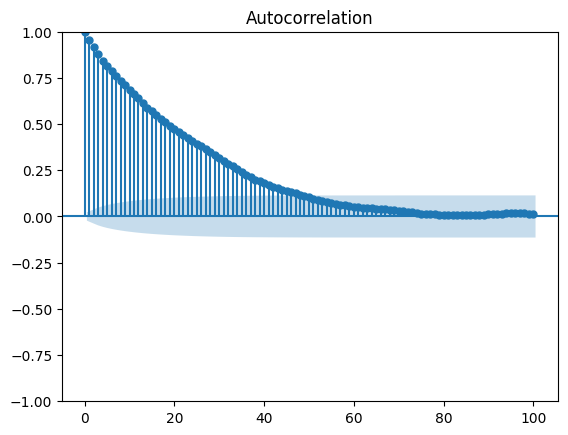

In [42]:
plot_acf(train, lags = 100)
plt.show()

All the lag values lying outside the shaded blue region are assumed to have a csorrelation. In the blue region perarson correlation is very low

#### ARIMA

In [46]:
# verify non stationry 
H, c,data = hurst.compute_Hc(train)
print("H = {:.4f}, c = {:.4f}".format(H,c))

H = 0.1660, c = 5.0740


The value of H<0.5 shows anti-persistent behavior, and H>0.5 shows persistent behavior or a trending series. H=0.5 shows random walk/Brownian motion. The value of H<0.5, confirming that our series is stationary.

In [53]:
model = ARIMA(train.values, order=(5, 0, 2))
model_fit = model.fit()

c:\Users\emanu\anaconda3\envs\hs01\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\emanu\anaconda3\envs\hs01\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\emanu\anaconda3\envs\hs01\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [55]:
predictions = model_fit.predict(len(test))
test_ = pd.DataFrame(test)
test_['predictions'] = predictions[0:1871]


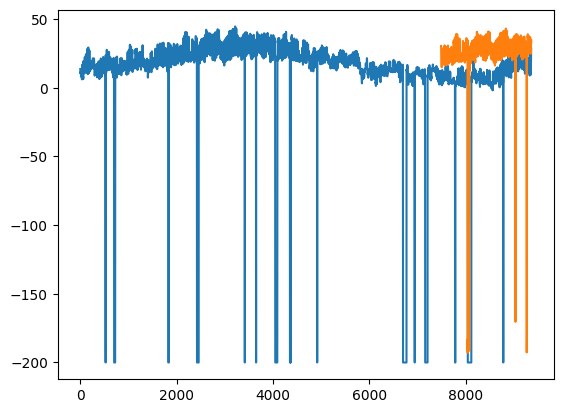

In [56]:
plt.plot(df['T'])
plt.plot(test_.predictions)
plt.show()
# on X axis is date but format is wrong !

In [57]:
error = sqrt(metrics.mean_squared_error(test.values,predictions[0:1871]))
print ('Test RMSE for ARIMA: ', error)

Test RMSE for ARIMA:  43.21341366059874


### LSTM 

In [63]:
def create_dataset(n_X, look_back):
   dataX, dataY = [], []
   for i in range(len(n_X)-look_back):
      a = n_X[i:(i+look_back), ]
      dataX.append(a)
      dataY.append(n_X[i + look_back, ])
   return np.array(dataX), np.array(dataY)

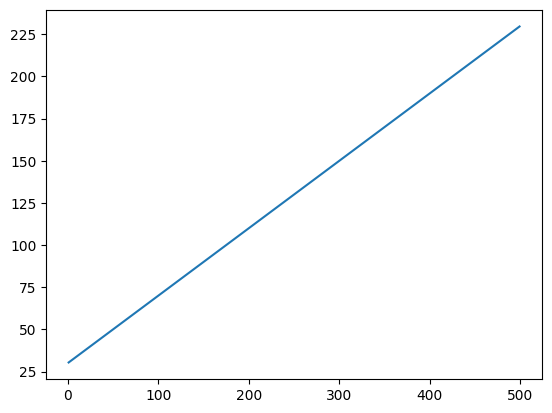

In [59]:
x = np.arange (1,500,1)
y = 0.4 * x + 30
plt.plot(x,y)

In [60]:
trainx, testx = x[0:int(0.8*(len(x)))], x[int(0.8*(len(x))):]
trainy, testy = y[0:int(0.8*(len(y)))], y[int(0.8*(len(y))):]
train = np.array(list(zip(trainx,trainy)))
test = np.array(list(zip(trainx,trainy)))

In [64]:
look_back = 1
trainx,trainy = create_dataset(train, look_back)
testx,testy = create_dataset(test, look_back)

trainx = np.reshape(trainx, (trainx.shape[0], 1, 2))
testx = np.reshape(testx, (testx.shape[0], 1, 2))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (trainx.shape[1], 2)))
model.add(LSTM(128,input_shape = (trainx.shape[1], 2)))
model.add(Dense(2))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainx, trainy, epochs = 20, batch_size = 10, verbose = 2, shuffle = False)
model.save_weights('LSTMBasic1.h5')